In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Put all the files into your Google Drive inside a file

In [43]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.cluster import KMeans
import seaborn as sns

In [4]:
path = '/content/drive/MyDrive/ML_Project/*.csv' #replace the emplacement
all_files = glob.glob(path) #to have all file at once
df = pd.concat([pd.read_csv(f) for f in all_files], ignore_index=True) #all filed linked into one


In [5]:
print(f"Total rows: {len(df)}")
df.head()

Total rows: 195568


,id,city,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,...,pharmacyDistance,ownership,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price
0,23d558163bb1c7863c73485048e50858,szczecin,NaN,53.80,2.0,5.0,5.0,NaN,53.429429,14.554642,...,0.073,cooperative,NaN,NaN,no,no,yes,no,no,420000
1,8373aa373dbc3fe7ca3b7434166b8766,szczecin,tenement,73.02,3.0,2.0,3.0,NaN,53.452222,14.553333,...,0.280,condominium,brick,NaN,no,no,no,no,no,565000
2,ede1c0d953ff85f3cd9676d39ca8f62d,szczecin,blockOfFlats,37.00,2.0,8.0,10.0,1970.0,53.442692,14.559690,...,0.205,cooperative,concreteSlab,NaN,no,yes,yes,yes,yes,429995
3,6c807c6c86a74c57a3fd4445a1f49a46,szczecin,apartmentBuilding,48.00,2.0,4.0,6.0,NaN,53.435461,14.570436,...,0.177,condominium,brick,NaN,no,yes,no,no,no,550000
4,bb14c9a540275da73f6cb6ed42e5c26c,szczecin,apartmentBuilding,55.19,2.0,1.0,2.0,2013.0,53.482094,14.542574,...,0.043,condominium,brick,premium,yes,yes,no,yes,yes,607000


In [7]:
df.info() #basic info
df.describe() #some stats
df.columns #check columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195568 entries, 0 to 195567
Data columns (total 28 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    195568 non-null  object 
 1   city                  195568 non-null  object 
 2   type                  153307 non-null  object 
 3   squareMeters          195568 non-null  float64
 4   rooms                 195568 non-null  float64
 5   floor                 160974 non-null  float64
 6   floorCount            193185 non-null  float64
 7   buildYear             163352 non-null  float64
 8   latitude              195568 non-null  float64
 9   longitude             195568 non-null  float64
 10  centreDistance        195568 non-null  float64
 11  poiCount              195568 non-null  float64
 12  schoolDistance        195400 non-null  float64
 13  clinicDistance        194840 non-null  float64
 14  postOfficeDistance    195320 non-null  float64
 15  

Index(['id', 'city', 'type', 'squareMeters', 'rooms', 'floor', 'floorCount',
       'buildYear', 'latitude', 'longitude', 'centreDistance', 'poiCount',
       'schoolDistance', 'clinicDistance', 'postOfficeDistance',
       'kindergartenDistance', 'restaurantDistance', 'collegeDistance',
       'pharmacyDistance', 'ownership', 'buildingMaterial', 'condition',
       'hasParkingSpace', 'hasBalcony', 'hasElevator', 'hasSecurity',
       'hasStorageRoom', 'price'],
      dtype='object')

We need to clean data, first by removing duplicates. Then count missing values per column. Then quick Exploratory analysis and then have a look on categorical columns.

In [8]:
print(f"Total rows before: {len(df)}")
exact_duplicates = df.duplicated().sum()
print(f"Exact duplicates: {exact_duplicates}")

Total rows before: 195568
Exact duplicates: 83600


In [9]:
key_columns = ['city', 'type', 'latitude', 'longitude', 'squareMeters', 'rooms', 'floor', 'buildYear']

df_clean = df.drop_duplicates(subset=key_columns, keep='last') #we remove the same apartments/house visible in different months.

print(f"Before: {len(df)} rows")
print(f"After: {len(df_clean)} rows")
print(f"Removed: {len(df) - len(df_clean)} duplicates")

Before: 195568 rows
After: 85953 rows
Removed: 109615 duplicates


In [10]:
df_clean.isnull().sum().sort_values(ascending=False)

,0
condition,64242
buildingMaterial,35937
type,18268
floor,14759
buildYear,14502
hasElevator,4121
collegeDistance,2283
floorCount,1019
clinicDistance,298
restaurantDistance,186


In [11]:
# First, make a proper copy to avoid warnings
df_clean = df_clean.copy()

# Categorical columns: fill with "Unknown"
categorical_cols = ['condition', 'buildingMaterial', 'type', 'hasElevator']
for col in categorical_cols:
    df_clean[col] = df_clean[col].fillna('Unknown')

# Numerical columns: fill with median
numerical_cols = ['floor', 'buildYear', 'floorCount',
                  'collegeDistance', 'clinicDistance', 'restaurantDistance',
                  'pharmacyDistance', 'postOfficeDistance', 'kindergartenDistance',
                  'schoolDistance']
for col in numerical_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())

# Verify no missing values left
print(df_clean.isnull().sum().sum())  # Should be 0

0


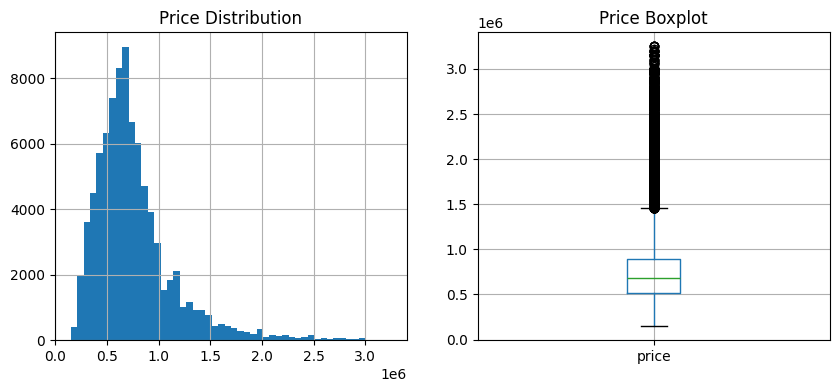

In [12]:
# Check target variable (price)
df_clean['price'].describe()

# Check for outliers in price
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
df_clean['price'].hist(bins=50)
plt.title('Price Distribution')

plt.subplot(1, 2, 2)
df_clean.boxplot(column='price')
plt.title('Price Boxplot')
plt.show()

Log transformation of price

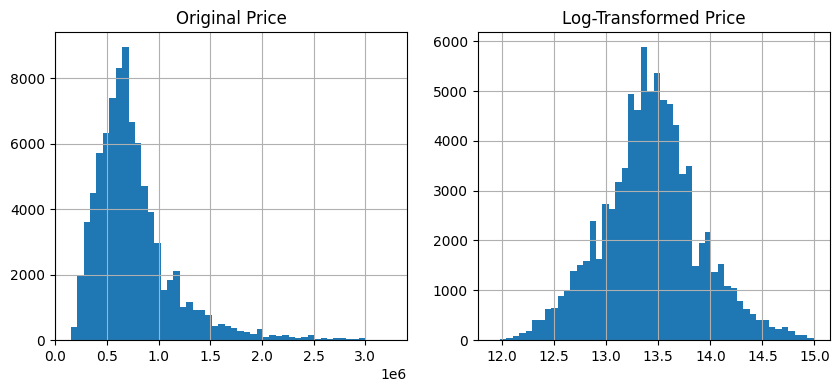

In [13]:
# Create log-transformed price
df_clean['log_price'] = np.log1p(df_clean['price'])

# Visualize
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
df_clean['price'].hist(bins=50)
plt.title('Original Price')

plt.subplot(1, 2, 2)
df_clean['log_price'].hist(bins=50)
plt.title('Log-Transformed Price')
plt.show()

In [14]:
# See unique values in categorical columns
print("Cities:", df_clean['city'].unique())
print("Types:", df_clean['type'].unique())
print("Condition:", df_clean['condition'].unique())

Cities: ['szczecin' 'gdynia' 'krakow' 'poznan' 'bialystok' 'gdansk' 'wroclaw'
 'radom' 'rzeszow' 'lodz' 'katowice' 'lublin' 'czestochowa' 'warszawa'
 'bydgoszcz']
Types: ['blockOfFlats' 'apartmentBuilding' 'tenement' 'Unknown']
Condition: ['Unknown' 'premium' 'low']


Prepare data for modelling

In [16]:
num_features = ['squareMeters', 'rooms', 'floor', 'floorCount', 'buildYear',
                'latitude', 'longitude', 'centreDistance', 'poiCount',
                'schoolDistance', 'clinicDistance', 'postOfficeDistance',
                'kindergartenDistance', 'restaurantDistance', 'collegeDistance',
                'pharmacyDistance']
cat_features = ['city', 'type', 'ownership', 'buildingMaterial', 'condition',
                'hasParkingSpace', 'hasBalcony', 'hasElevator', 'hasSecurity',
                'hasStorageRoom']

df_encoded = pd.get_dummies(df_clean, columns=cat_features, drop_first=True)

X = df_encoded.drop(['price', 'log_price', 'id'], axis=1)
y = df_encoded['log_price']  # Use log-transformed price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (68762, 45)
Test set: (17191, 45)


In [19]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

LinearRegression()

In [21]:
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_lr


array([13.45874064, 14.06909895, 13.12219836, ..., 12.64482046,
       13.79271557, 13.38824486])

In [22]:
print("=== Linear Regression Results ===")
print(f"R² Score: {r2_score(y_test, y_pred_lr):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr)):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lr):.4f}")


=== Linear Regression Results ===
R² Score: 0.8335
RMSE: 0.1902
MAE: 0.1463


In [24]:
# Convert back to original price scale for MAPE
y_test_original = np.expm1(y_test)
y_pred_original = np.expm1(y_pred_lr)

In [25]:
mape = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100
print(f"MAPE: {mape:.2f}%")

MAPE: 14.81%


In [28]:
results = {'Linear Regression': 14.81}

In [29]:
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train_scaled, y_train)
y_pred_dt = dt_model.predict(X_test_scaled)
y_pred_dt_orig = np.expm1(y_pred_dt)
mape_dt = np.mean(np.abs((y_test_original - y_pred_dt_orig) / y_test_original)) * 100
results['Decision Tree'] = mape_dt
print(f"Decision Tree MAPE: {mape_dt:.2f}%")

Decision Tree MAPE: 13.55%


In [30]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_rf_orig = np.expm1(y_pred_rf)
mape_rf = np.mean(np.abs((y_test_original - y_pred_rf_orig) / y_test_original)) * 100
results['Random Forest'] = mape_rf
print(f"Random Forest MAPE: {mape_rf:.2f}%")

Random Forest MAPE: 10.03%


In [31]:
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train_scaled, y_train)
y_pred_gb = gb_model.predict(X_test_scaled)
y_pred_gb_orig = np.expm1(y_pred_gb)
mape_gb = np.mean(np.abs((y_test_original - y_pred_gb_orig) / y_test_original)) * 100
results['Gradient Boosting'] = mape_gb
print(f"Gradient Boosting MAPE: {mape_gb:.2f}%")

Gradient Boosting MAPE: 13.12%


In [32]:
knn_model = KNeighborsRegressor(n_neighbors=5, n_jobs=-1)
knn_model.fit(X_train_scaled, y_train)
y_pred_knn = knn_model.predict(X_test_scaled)
y_pred_knn_orig = np.expm1(y_pred_knn)
mape_knn = np.mean(np.abs((y_test_original - y_pred_knn_orig) / y_test_original)) * 100
results['k-NN'] = mape_knn
print(f"k-NN MAPE: {mape_knn:.2f}%")

k-NN MAPE: 15.42%


In [34]:
# XGBoost
xgb_model = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_pred_xgb_orig = np.expm1(y_pred_xgb)
mape_xgb = np.mean(np.abs((y_test_original - y_pred_xgb_orig) / y_test_original)) * 100
results['XGBoost'] = mape_xgb
print(f"XGBoost MAPE: {mape_xgb:.2f}%")

XGBoost MAPE: 11.18%


In [36]:
results['XGBoost'] = 11.18

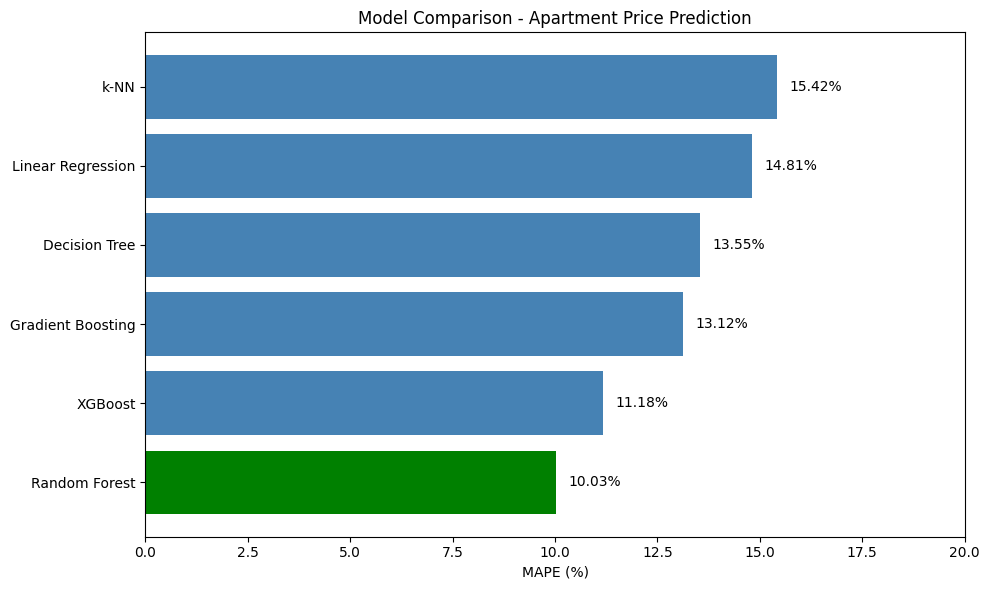

In [37]:
sorted_results = dict(sorted(results.items(), key=lambda x: x[1]))

plt.figure(figsize=(10, 6))
colors = ['green' if v == min(results.values()) else 'steelblue' for v in sorted_results.values()]
plt.barh(list(sorted_results.keys()), list(sorted_results.values()), color=colors)
plt.xlabel('MAPE (%)')
plt.title('Model Comparison - Apartment Price Prediction')
plt.xlim(0, 20)


for i, (model, mape) in enumerate(sorted_results.items()):
    plt.text(mape + 0.3, i, f'{mape:.2f}%', va='center')

plt.tight_layout()
plt.show()

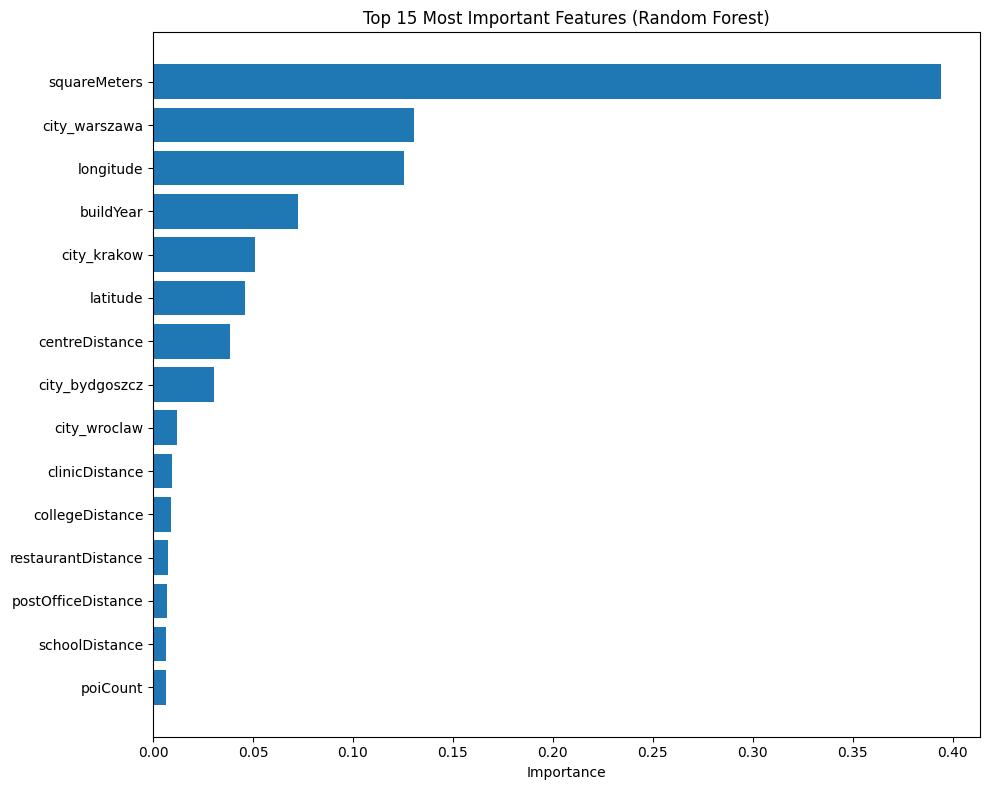

               feature  importance
0         squareMeters    0.393956
28       city_warszawa    0.130512
6            longitude    0.125473
4            buildYear    0.072416
21         city_krakow    0.050866
5             latitude    0.045809
7       centreDistance    0.038614
16      city_bydgoszcz    0.030507
29        city_wroclaw    0.012138
10      clinicDistance    0.009341
14     collegeDistance    0.009081
13  restaurantDistance    0.007470
11  postOfficeDistance    0.007156
9       schoolDistance    0.006658
8             poiCount    0.006594


In [38]:
# Feature importance from Random Forest (best model)
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(10, 8))
top_15 = feature_importance.head(15)
plt.barh(top_15['feature'], top_15['importance'])
plt.xlabel('Importance')
plt.title('Top 15 Most Important Features (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(feature_importance.head(15))

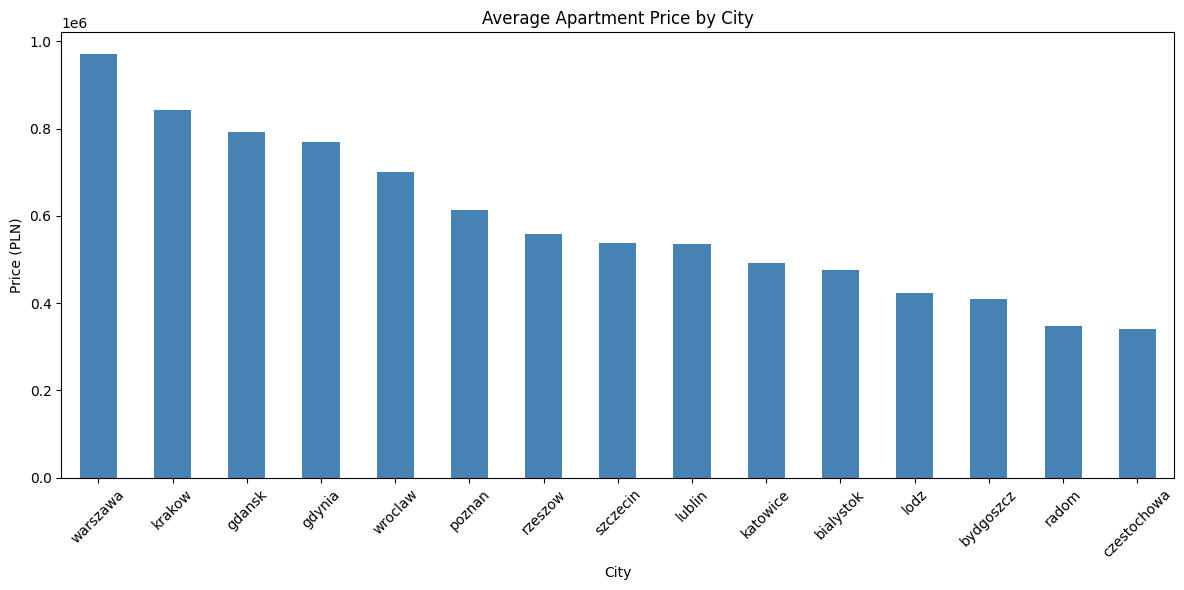

city
warszawa       971919.097673
krakow         841619.343864
gdansk         793071.554874
gdynia         768220.690415
wroclaw        700216.202848
poznan         612912.988791
rzeszow        559339.803789
szczecin       536517.872695
lublin         534990.432552
katowice       492033.242342
bialystok      474932.069201
lodz           421870.613302
bydgoszcz      408517.501754
radom          346886.081967
czestochowa    339792.586146
Name: price, dtype: float64


In [39]:
# Average price by city
price_by_city = df_clean.groupby('city')['price'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
price_by_city.plot(kind='bar', color='steelblue')
plt.title('Average Apartment Price by City')
plt.ylabel('Price (PLN)')
plt.xlabel('City')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(price_by_city)

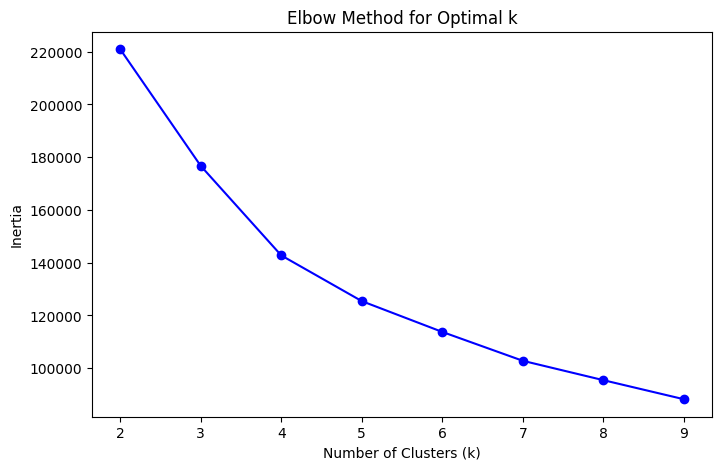

In [41]:
cluster_features = ['squareMeters', 'rooms', 'price', 'centreDistance']
df_cluster = df_clean[cluster_features].copy()

# Scale the features
scaler_cluster = StandardScaler()
df_cluster_scaled = scaler_cluster.fit_transform(df_cluster)

# Find optimal k using elbow method
inertias = []
K_range = range(2, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_cluster_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

Cluster Analysis:
              price  squareMeters  rooms  centreDistance
cluster                                                 
0        1539369.54         97.02   4.00            4.74
1         583096.97         42.37   1.88            4.30
2         777759.45         62.79   3.11            4.86


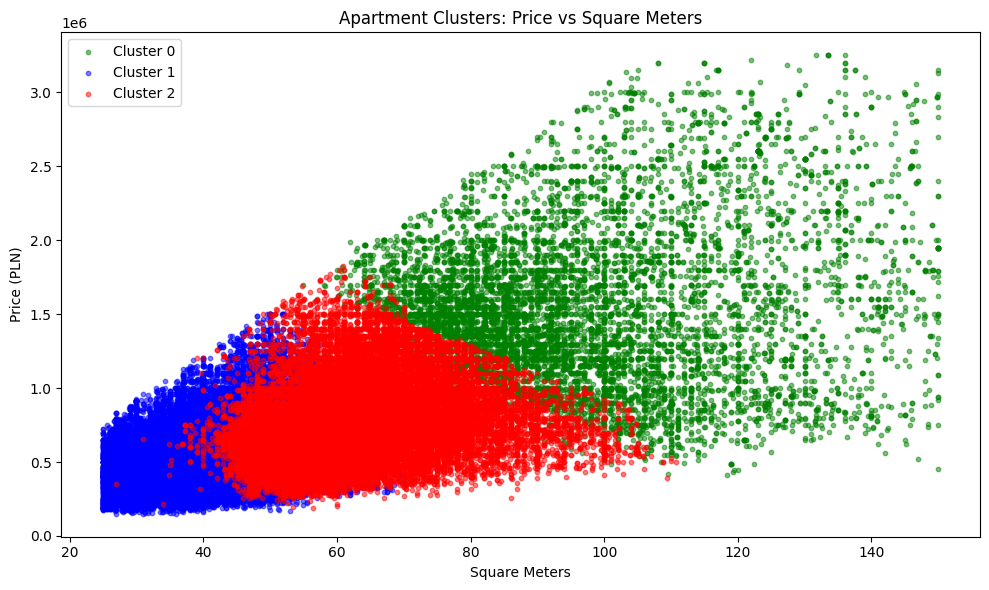


Apartments per cluster:
cluster
0     8912
1    42652
2    34389
Name: count, dtype: int64


In [42]:
# Apply K-means with k=3
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_clean['cluster'] = kmeans.fit_predict(df_cluster_scaled)

# Analyze clusters
cluster_analysis = df_clean.groupby('cluster').agg({
    'price': 'mean',
    'squareMeters': 'mean',
    'rooms': 'mean',
    'centreDistance': 'mean'
}).round(2)

print("Cluster Analysis:")
print(cluster_analysis)

# Visualize clusters
plt.figure(figsize=(10, 6))
colors = ['green', 'blue', 'red']
labels = ['Budget', 'Mid-Range', 'Luxury']

for i in range(3):
    cluster_data = df_clean[df_clean['cluster'] == i]
    plt.scatter(cluster_data['squareMeters'], cluster_data['price'],
                c=colors[i], label=f'Cluster {i}', alpha=0.5, s=10)

plt.xlabel('Square Meters')
plt.ylabel('Price (PLN)')
plt.title('Apartment Clusters: Price vs Square Meters')
plt.legend()
plt.tight_layout()
plt.show()

# Count per cluster
print("\nApartments per cluster:")
print(df_clean['cluster'].value_counts().sort_index())

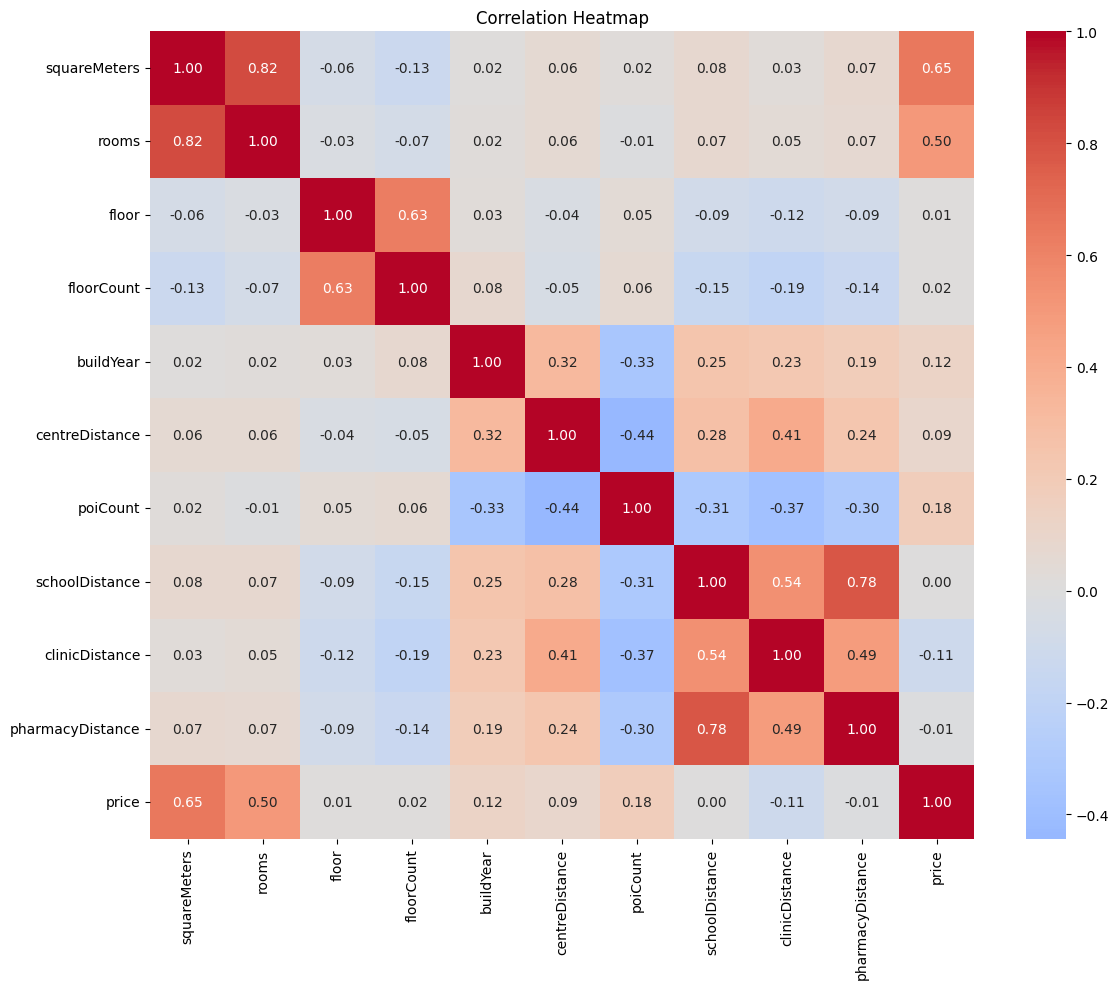

In [44]:
# Select numerical columns
num_cols = ['squareMeters', 'rooms', 'floor', 'floorCount', 'buildYear',
            'centreDistance', 'poiCount', 'schoolDistance', 'clinicDistance',
            'pharmacyDistance', 'price']

# Compute correlation matrix
corr_matrix = df_clean[num_cols].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

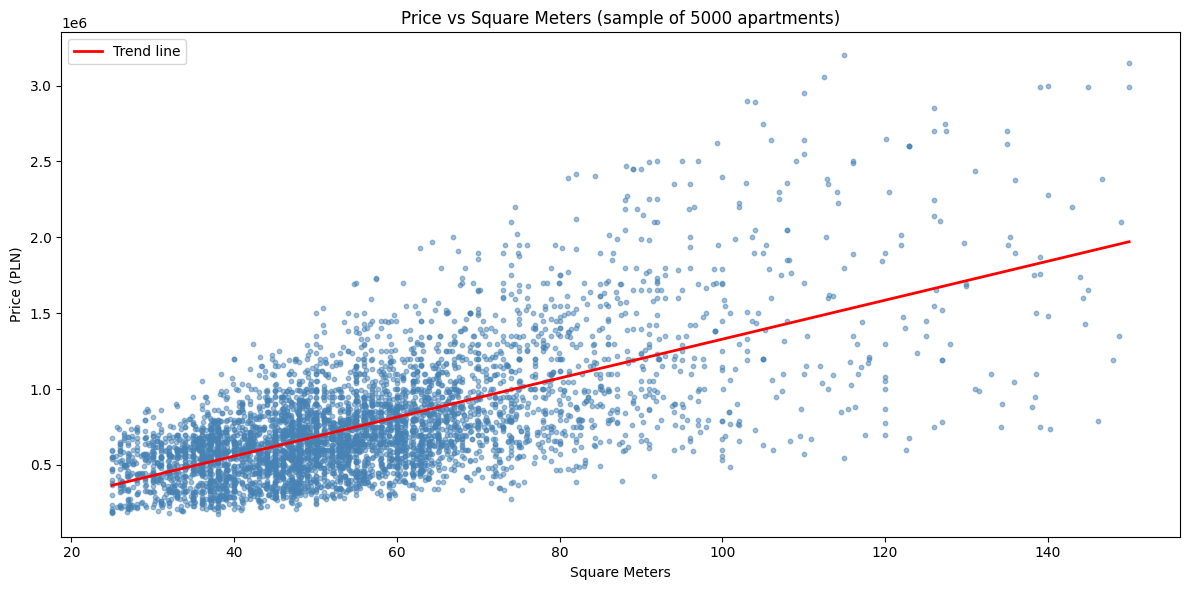

Average price per m² by city:
city
warszawa       17177.45
krakow         15643.17
gdansk         14246.00
wroclaw        12836.23
gdynia         12568.13
poznan         10874.26
rzeszow        10029.33
lublin          9375.07
bialystok       9232.05
szczecin        9181.37
katowice        8549.73
lodz            8220.29
bydgoszcz       7837.21
czestochowa     6627.77
radom           6580.39
Name: price_per_m2, dtype: float64


In [45]:
# Price vs Square Meters (most important relationship)
plt.figure(figsize=(12, 6))

# Sample data for better visualization (too many points)
sample = df_clean.sample(n=5000, random_state=42)

plt.scatter(sample['squareMeters'], sample['price'], alpha=0.5, c='steelblue', s=10)
plt.xlabel('Square Meters')
plt.ylabel('Price (PLN)')
plt.title('Price vs Square Meters (sample of 5000 apartments)')

# Add trend line
z = np.polyfit(sample['squareMeters'], sample['price'], 1)
p = np.poly1d(z)
x_line = np.linspace(sample['squareMeters'].min(), sample['squareMeters'].max(), 100)
plt.plot(x_line, p(x_line), "r-", linewidth=2, label=f'Trend line')

plt.legend()
plt.tight_layout()
plt.show()

# Price per m² by city
df_clean['price_per_m2'] = df_clean['price'] / df_clean['squareMeters']
print("Average price per m² by city:")
print(df_clean.groupby('city')['price_per_m2'].mean().sort_values(ascending=False).round(2))